Import Block

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Data Exploratory


In [27]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-cabai-rawit-merah-malang-2017-2021.csv?token=ARB4LTDT5GLD32BLYNOGHU3AXY7XE \
    -O /tmp/chilli.csv

--2021-05-31 16:17:41--  https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-cabai-rawit-merah-malang-2017-2021.csv?token=ARB4LTDT5GLD32BLYNOGHU3AXY7XE
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15873 (16K) [text/plain]
Saving to: ‘/tmp/chilli.csv’

/tmp/chilli.csv     100%[===================>]  15.50K  --.-KB/s    in 0s      

2021-05-31 16:17:41 (105 MB/s) - ‘/tmp/chilli.csv’ saved [15873/15873]



In [28]:
#Read dataset with pandas, then put it to chilli_df variable
chilli_df = pd.read_csv('/tmp/chilli.csv')
chilli_df

tanggal  harga
0    2017-08-02  26000
1    2017-08-03  26000
2    2017-08-04  26000
3    2017-08-07  26000
4    2017-08-08  26000
..          ...    ...
935  2021-05-24  12500
936  2021-05-25  12500
937  2021-05-27  24500
938  2021-05-28  24500
939  2021-05-31  24500

[940 rows x 2 columns]

In [29]:
#Inspect the first 5 of chilli_df dataframe
chilli_df.head()

tanggal  harga
0  2017-08-02  26000
1  2017-08-03  26000
2  2017-08-04  26000
3  2017-08-07  26000
4  2017-08-08  26000

In [30]:
#Inspect the last 5 of chilli_df dataframe
chilli_df.tail()

tanggal  harga
935  2021-05-24  12500
936  2021-05-25  12500
937  2021-05-27  24500
938  2021-05-28  24500
939  2021-05-31  24500

In [31]:
#Inspect the describtion of chilli_df dataframe
chilli_df.describe()

harga
count     940.000000
mean    26848.404255
std     19503.120162
min      6000.000000
25%     12500.000000
50%     19500.000000
75%     35000.000000
max    105000.000000

In [32]:
#Casting harga's column to float
chilli_df['harga'] = pd.to_numeric(chilli_df['harga'], downcast='float')
print(chilli_df)
print(chilli_df.dtypes)

        tanggal    harga
0    2017-08-02  26000.0
1    2017-08-03  26000.0
2    2017-08-04  26000.0
3    2017-08-07  26000.0
4    2017-08-08  26000.0
..          ...      ...
935  2021-05-24  12500.0
936  2021-05-25  12500.0
937  2021-05-27  24500.0
938  2021-05-28  24500.0
939  2021-05-31  24500.0

[940 rows x 2 columns]
tanggal     object
harga      float32
dtype: object


In [33]:
#Normalize harga's column data by dividing it with the largest number
max = chilli_df['harga'].max()
chilli_df['harga'] /= max

In [34]:
chilli_df

tanggal     harga
0    2017-08-02  0.247619
1    2017-08-03  0.247619
2    2017-08-04  0.247619
3    2017-08-07  0.247619
4    2017-08-08  0.247619
..          ...       ...
935  2021-05-24  0.119048
936  2021-05-25  0.119048
937  2021-05-27  0.233333
938  2021-05-28  0.233333
939  2021-05-31  0.233333

[940 rows x 2 columns]

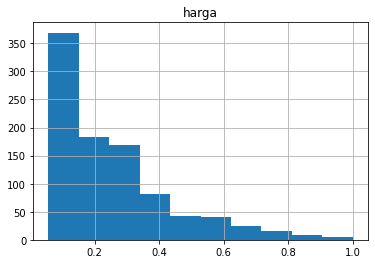

In [35]:
_ = chilli_df.hist()

In [36]:
#Get the price and time step from dataframe
temp = chilli_df['harga']
price = np.array(temp.tolist())
time = np.array([i[0] for i in enumerate(price)])

In [37]:
#Helper function for plotting dataset
def plot_dataset(time, series, title, xlabel, ylabel, color='b'):
  plt.plot(time, series, '{}-'.format(color))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid=True

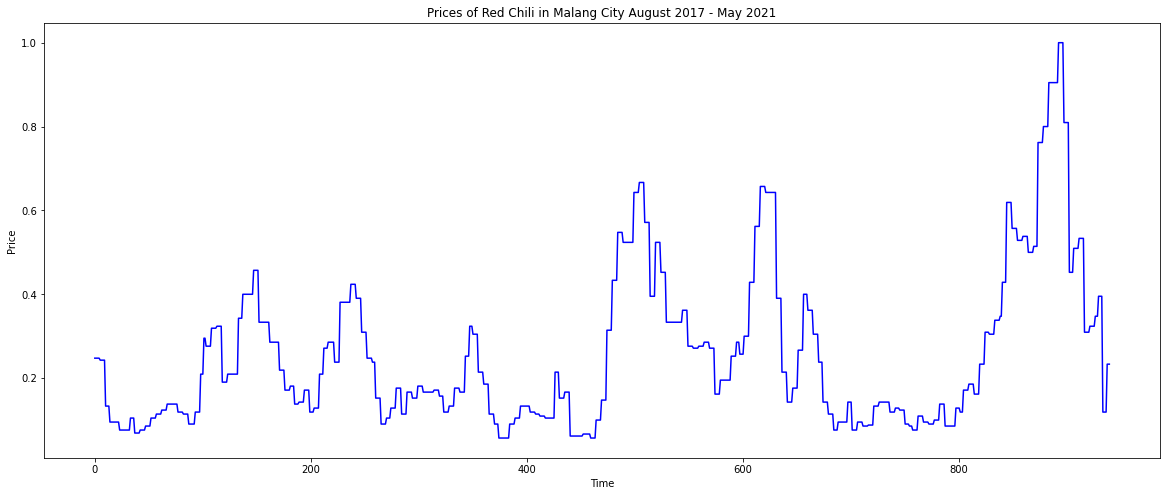

In [38]:
#Plot the dataset
plt.figure(figsize=(20, 8))
plot_dataset(time=time, series=price, color='b', title='Prices of Red Chili in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

Split Train and Test

In [39]:
#Split dataset with 70% of training, 20% for validation, and the rest for testing
split = round(0.7*len(price))
split_val = round(0.9*len(price))
train_price = price[:split]
train_time = time[:split]
val_price = price[split:split_val]
val_time = time[split:split_val]
test_price = price[split_val:]
test_time = time[split_val:]

Window the Dataset 

In [40]:
#Helper function for windowing the dataset
def dataset_window(list, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(temp, axis=-1)
  data_window = tf.data.Dataset.from_tensor_slices(series)
  data_window = data_window.window(window_size + 1, shift = 1, drop_remainder= True)
  data_window = data_window.flat_map(lambda x: x.batch(window_size+1))
  data_window = data_window.shuffle(shuffle_buffer)
  data_window = data_window.map(lambda x: (x[:-1], x[1:]))
  data_window = data_window.batch(batch_size).prefetch(1)
  return data_window

Function for Forecasting the Model for Fit It Into the Plotted Graph

In [41]:
#Helper function for forecasting
def forecast_model(model, series, window_size):
  data_forecast = tf.data.Dataset.from_tensor_slices(series)
  data_forecast = data_forecast.window(window_size, shift=1, drop_remainder=True)
  data_forecast = data_forecast.flat_map(lambda x: x.batch(window_size))
  data_forecast = data_forecast.batch(32).prefetch(1)
  print(data_forecast)
  forecast = model.predict(data_forecast)
  return forecast

Window Size,Batch Size, & Shuffle Buffer Variable

In [42]:
window_size = 20
batch_size = 512
shuffle_buffer = 1000

Build the Model

In [18]:
#Building model with learning rate scheduler, so we can pick the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)

print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda x: 1e-8 * 10**(x/20))
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=200, callbacks=[learning_rate_scheduler])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/200
2/2 [==============================] - 34s 92ms/step - loss: 0.0541 - mean_absolute_error: 0.2658
Epoch 2/200
2/2 [==============================] - 0s 12ms/step - loss: 0.0541 - mean_absolute_error: 0.2658
Epoch 3/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0541 - mean_absolute_error: 0.2658
Epoch 4/200
2/2 [==============================] - 0s 13ms/step - loss: 0.0541 - mean_absolute_error: 0.2658
Epoch 5/200
2/2 [==============================] - 0s 13ms/step - loss: 0.0541 - mean_absolute_error: 0.2658
Epoch 6/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0541 - mean_absolute_error: 0.2658
Epoch 7/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0541 - mean_absolute_error: 0.2658
Epoch 8/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0541 - mean_absolute_error: 0.2658
Epoch 9/200
2/2 [=========

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
dense (Dense)                (None, None, 16)          528       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           17        
Total params: 9,057
Trainable params: 9,057
Non-trainable params: 0
_________________________________________________________________


(1e-05, 0.1, 0.0, 0.2)

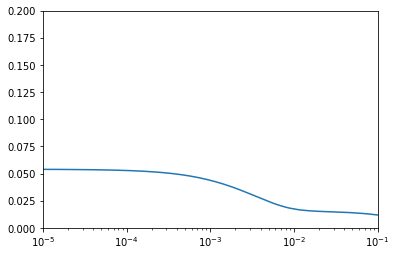

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 0.2])

In [43]:
#Build the final model with the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)
val_set = dataset_window(val_price, window_size, batch_size, shuffle_buffer)
print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=300, validation_data=val_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/300
2/2 [==============================] - 2s 521ms/step - loss: 0.0344 - mean_absolute_error: 0.1979 - val_loss: 0.0147 - val_mean_absolute_error: 0.1163
Epoch 2/300
2/2 [==============================] - 0s 120ms/step - loss: 0.0143 - mean_absolute_error: 0.1266 - val_loss: 0.0196 - val_mean_absolute_error: 0.1751
Epoch 3/300
2/2 [==============================] - 0s 106ms/step - loss: 0.0218 - mean_absolute_error: 0.1859 - val_loss: 0.0223 - val_mean_absolute_error: 0.1892
Epoch 4/300
2/2 [==============================] - 0s 107ms/step - loss: 0.0193 - mean_absolute_error: 0.1735 - val_loss: 0.0110 - val_mean_absolute_error: 0.1179
Epoch 5/300
2/2 [==============================] - 0s 110ms/step - loss: 0.0112 - mean_absolute_error: 0.1121 - val_loss: 0.0152 - val_mean_absolute_error: 0.1130
Epoch 6/300
2/2 [==============================] - 0s 117ms/step - loss: 0.0160 - me

In [44]:
#Forecasting the testing data
rnn_forecast = forecast_model(model, price[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_val - window_size:-1, -1, 0]

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


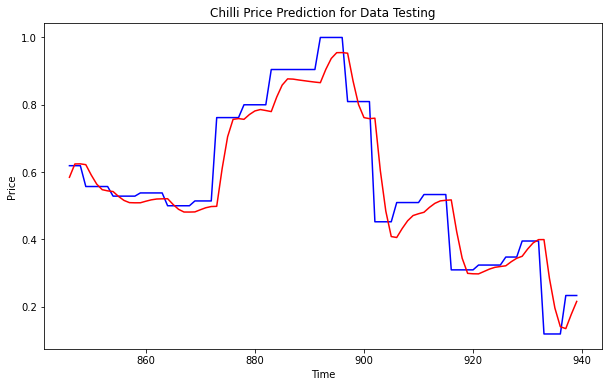

In [45]:
#Plotting the testing data
plt.figure(figsize=(10, 6))
plot_dataset(time=test_time, series=test_price, title='Chilli Price Prediction for Data Testing',xlabel='Time', ylabel='Price')
plot_dataset(time=test_time, series=rnn_forecast, title='Chilli Price Prediction for Data Testing', xlabel='Time', ylabel='Price', color='r')

<Figure size 432x288 with 0 Axes>

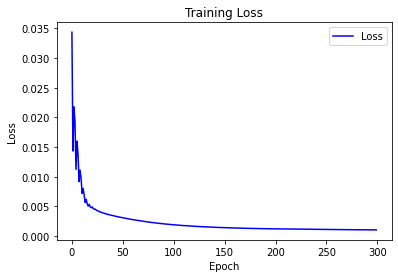

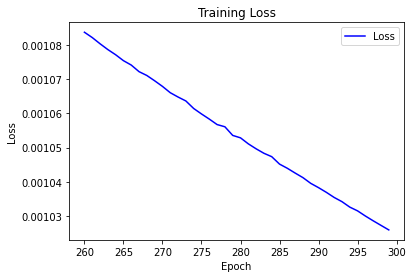

<Figure size 432x288 with 0 Axes>

In [46]:
#Plotting and examining the training loss
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epoch_num=range(len(loss))

plot_dataset(epoch_num, loss, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

loss_zoom = loss[260:]
epoch_num_zoom = [x+260 for x in range(len(loss_zoom))]

plot_dataset(epoch_num_zoom, loss_zoom, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

In [47]:
rnn_forecast

array([0.58460873, 0.6241827 , 0.62448907, 0.6220993 , 0.5912826 ,
       0.5642933 , 0.5478082 , 0.54426575, 0.54218966, 0.52770776,
       0.5158624 , 0.50926405, 0.50875324, 0.5088483 , 0.51341856,
       0.5175336 , 0.5200466 , 0.52058077, 0.52090484, 0.50394136,
       0.4894653 , 0.48137707, 0.4812947 , 0.4817096 , 0.4880994 ,
       0.494084  , 0.49767843, 0.49829733, 0.6108029 , 0.70510983,
       0.75672334, 0.7589609 , 0.75682485, 0.7710814 , 0.7816869 ,
       0.78584194, 0.78294426, 0.779773  , 0.822908  , 0.8584451 ,
       0.87698627, 0.87626904, 0.87375   , 0.8715848 , 0.86940604,
       0.8674057 , 0.8656922 , 0.90505564, 0.93758994, 0.9548296 ,
       0.95502716, 0.9532748 , 0.8704902 , 0.8006993 , 0.76184   ,
       0.75877905, 0.76014775, 0.6039218 , 0.484155  , 0.40849283,
       0.40565947, 0.4322459 , 0.45529824, 0.47091454, 0.47627804,
       0.4806436 , 0.49515837, 0.5071968 , 0.5144664 , 0.5162948 ,
       0.51733077, 0.42273587, 0.34419042, 0.299168  , 0.29784

In [48]:
temp = len(test_price)-21
temp_1 = len(test_price)-1
temp=test_price[temp:temp_1]

In [49]:
rnn_forecast = forecast_model(model, temp[..., np.newaxis],len(temp)).tolist()
rnn_forecast

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


[[[0.26481756567955017],
  [0.3137200176715851],
  [0.341569185256958],
  [0.3209362328052521],
  [0.31607791781425476],
  [0.3131583333015442],
  [0.3123612701892853],
  [0.3232312798500061],
  [0.3333699703216553],
  [0.33988237380981445],
  [0.3624081015586853],
  [0.38184455037117004],
  [0.3930460810661316],
  [0.39446941018104553],
  [0.28031015396118164],
  [0.1930103600025177],
  [0.13822078704833984],
  [0.1336173415184021],
  [0.17650771141052246],
  [0.21577200293540955]]]

In [50]:
round(rnn_forecast[-1][-1][0]*max)

22656

In [51]:
pred = model.predict([[[24500/max]]])

In [52]:
pred.tolist()[0][0][0]*max

23857.718110084534

In [53]:
model.save("red_chilli_model")

INFO:tensorflow:Assets written to: red_chilli_model/assets


INFO:tensorflow:Assets written to: red_chilli_model/assets


In [54]:
!zip -r red_chilli_model.zip red_chilli_model

  adding: red_chilli_model/ (stored 0%)
  adding: red_chilli_model/assets/ (stored 0%)
  adding: red_chilli_model/keras_metadata.pb (deflated 89%)
  adding: red_chilli_model/saved_model.pb (deflated 89%)
  adding: red_chilli_model/variables/ (stored 0%)
  adding: red_chilli_model/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: red_chilli_model/variables/variables.index (deflated 63%)
